## **Cat vs Dog Classification**
**Note:** Libraires are imported at the start of each section for my convenience

In [ ]:
import os
os.listdir('./')

### **Workflow**

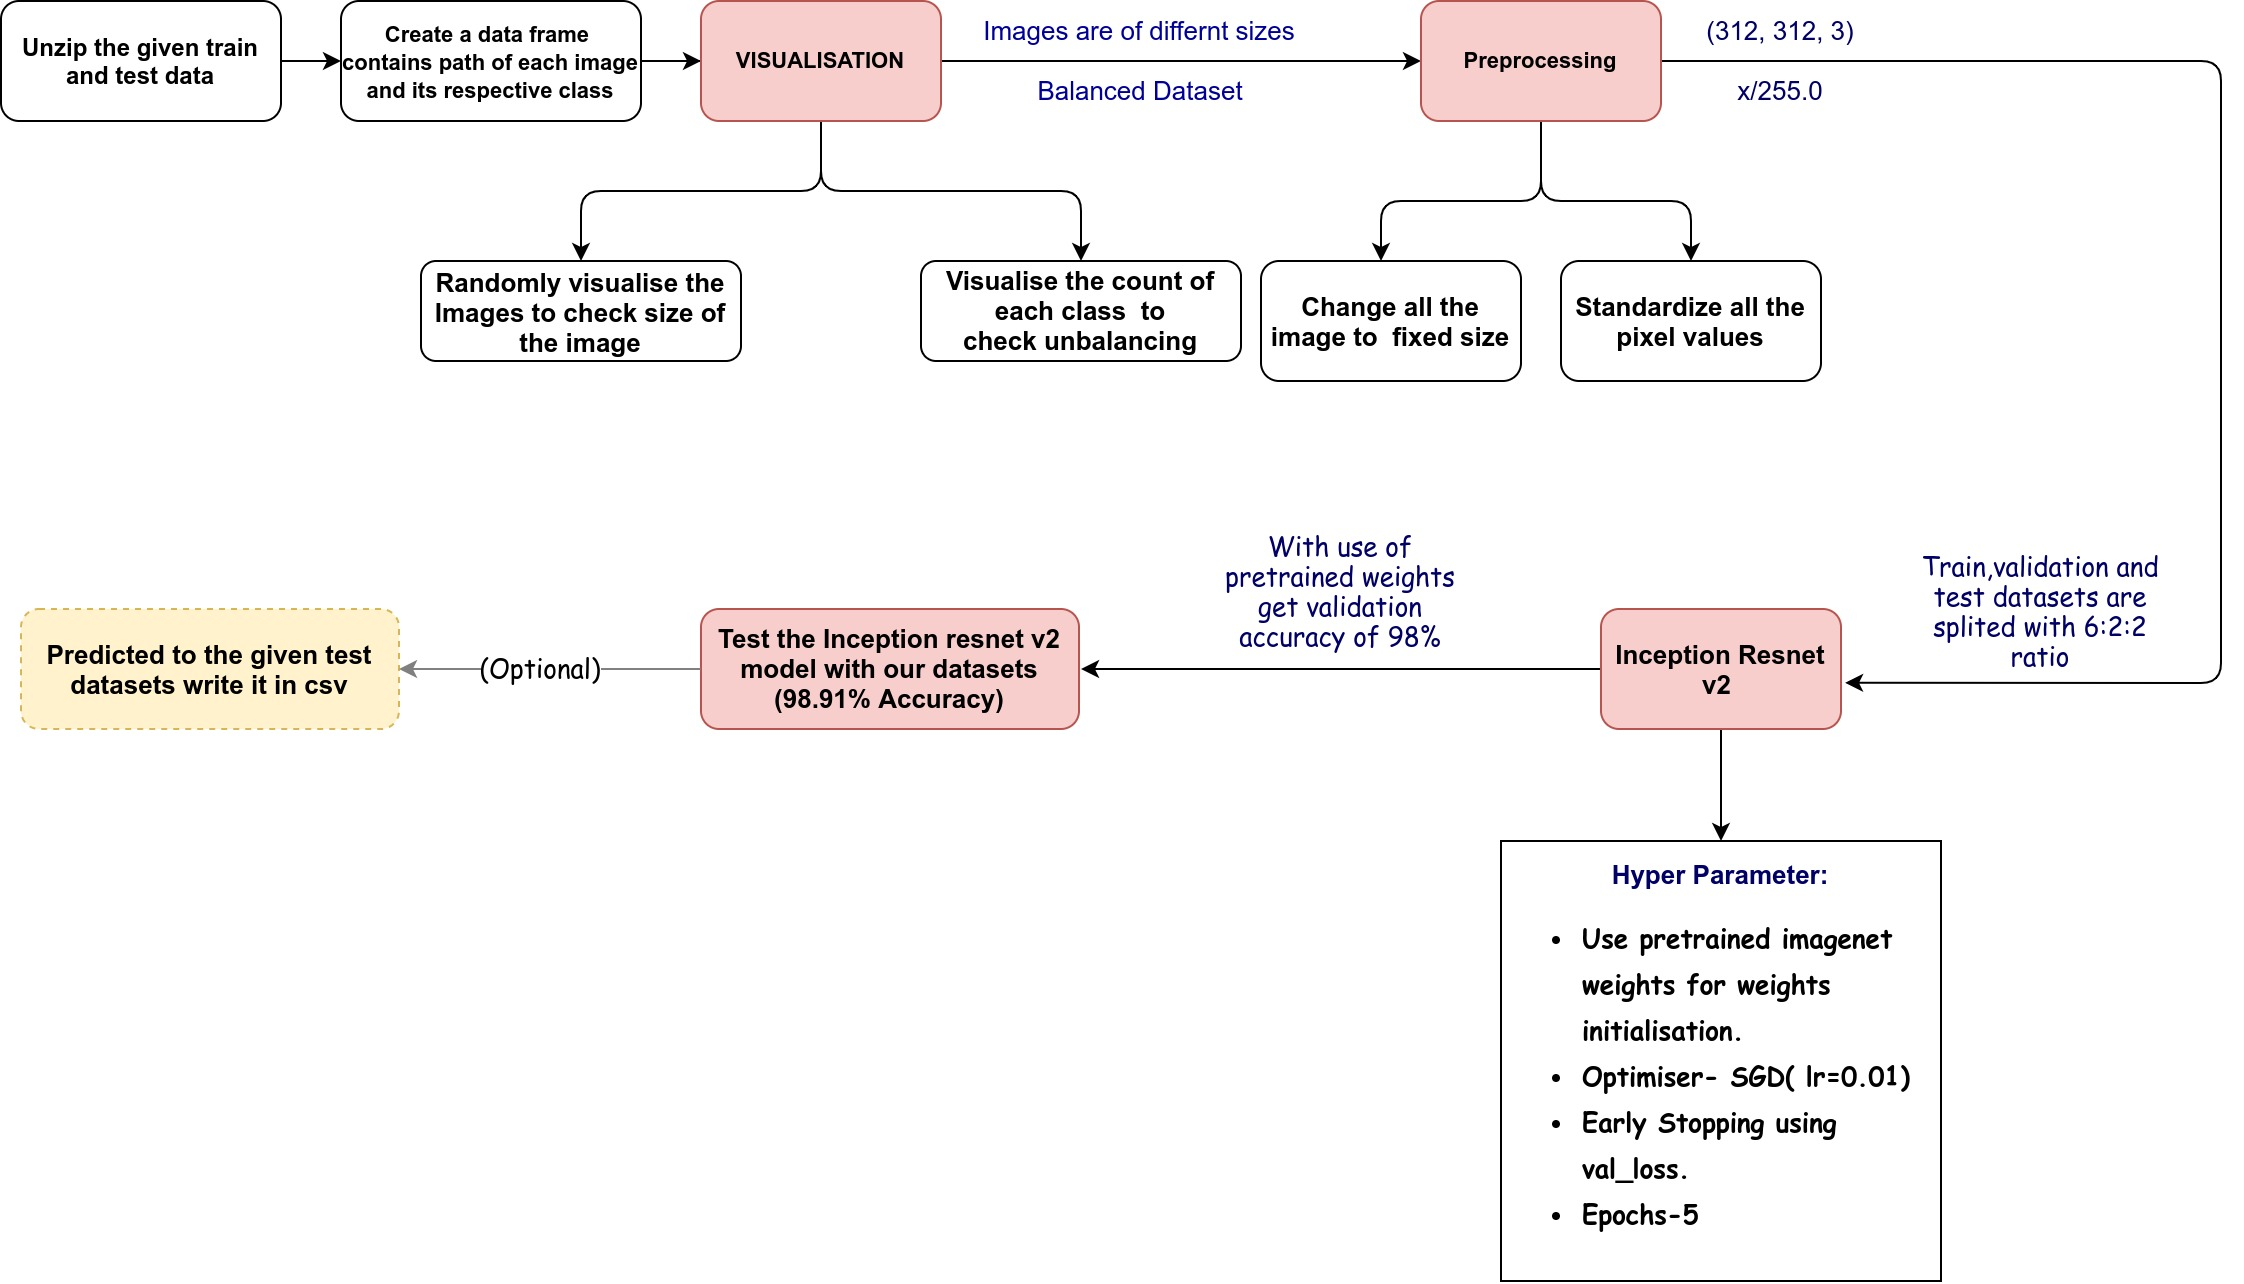

### **Extracting the train and test data**

In [ ]:
# Extractig the training data
import zipfile
from tqdm import tqdm
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip") as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, "./")
        except zipfile.error as e:
            pass

In [ ]:
# Extracting the testing data
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip") as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, "./")
        except zipfile.error as e:
            pass

In [ ]:
import os
os.listdir('./')

### **write the datafame with each image path and respective image class (0 or 1)**

In [ ]:
# create separate list to store target class (0 or 1) and respective image path
train_filenames=os.listdir('./train')
path=[]
target=[]
for i in train_filenames:
    temp=i.split('.')[0]
    if temp=='cat':
        target.append(0)
    else:
        target.append(1)
    path.append('./train/'+i)

In [ ]:
import pandas as pd
data={'Image': path,'Target': target}
df=pd.DataFrame(data)
df.head()


In [ ]:
df.describe()

## **Visualisation**

### **Check all the images are of same size using simple visualisation**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
fig = plt.figure(figsize=(10,10))

random.seed(15)
random_list=random.sample(range(0,24999),9)
for i,index in enumerate(random_list):
    plt.subplot(330+1+i)
    file_path=df.loc[index]['Image']
    img=imread(file_path)
    plt.imshow(img)
plt.show()

####  ***Note: Not all the images are of same sizes***

### **Check the class imbalancing**

In [ ]:
import seaborn as sns
ax=sns.countplot(data=df,x='Target')

#### ***Note: Dataset is Balanced***

### **Split the dataset to train(60%),validation(20%),test(20%)**

In [ ]:
import sklearn.model_selection as sk
import numpy as np

train_x, val1_x, train_y, val1_y = sk.train_test_split(path,target,test_size=0.4, random_state=42)
val_x,test_x,val_y,test_y=sk.train_test_split(val1_x,val1_y,test_size=0.5, random_state=42)
print('Training data:', len(train_x))
print('Training Label:', len(train_y))
print('Validation Data:',len(val_x))
print('Validation Label:', len(val_y))
print('Test Data:',len(test_x))
print('Test Label:', len(test_y))
print('-------------------------------------------')
print('Total Data:', len(train_x)+len(val_x)+len(test_x))

### **Preprocessing of the image**

In [ ]:
import cv2
from albumentations import (
    Compose, ToFloat
)

### **Changing all the pixel values to float**

> I preprocessed using albumentation, If data quantity is low we can include augmentation inside `AUGMENTATIONS_TRAIN` and use it for a real time augmentation.

In [ ]:
AUGMENTATIONS_TRAIN = Compose([
    ToFloat(max_value=255)
])

In [ ]:
AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

### **Data Generators inherits from keras.sequence class**
> 
> **Our dataset is too large to fit in memory, we have to load the dataset from the hard disk in batches to our memory.**
>  
> * `keras.sequence` class is inherited in `Cat_Dog_Sequence` to split the data to fit into the memory dynamically.
> * Split the data into batches(for each batch 16 images).
> * Resize the Image to 312*312 


In [ ]:
from tensorflow.keras.utils import Sequence
import cv2

In [ ]:
# for training data
class Cat_Dog_Sequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations, shape):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.shape = shape

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.stack([
            self.augment(image=cv2.resize(cv2.imread(x, 1), self.shape))["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

In [ ]:
#for Testing data
class Cat_Dog_Test_Sequence(Sequence):
    def __init__(self, x_set,batch_size, augmentations, shape):
        self.x = x_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.shape = shape

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.stack([
            self.augment(image=cv2.resize(cv2.imread(x, 1), self.shape))["image"] for x in batch_x
        ], axis=0)

In [ ]:
train_y=np.array(train_y).reshape((len(train_y),1))
val_y=np.array(val_y).reshape((len(val_y),1))

In [ ]:
# Initialise the data generators
train_gen=Cat_Dog_Sequence(train_x,train_y,16, augmentations=AUGMENTATIONS_TRAIN,shape=(312,312))
val_gen=Cat_Dog_Sequence(val_x,val_y,16, augmentations=AUGMENTATIONS_TEST,shape=(312,312))

### **Inception Resnet v2 model is used from keras.application to get the pretrained weights**

> Pretrained Imagenet weights of InceptionResnetv2 is used.

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
model=InceptionResNetV2(include_top=False, weights='imagenet',input_shape=[312,312,3])

In [ ]:
model.summary()

#### **Add a head to our classification**

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import Model
x=model.output

#x=Flatten(name='Flatten')(x)
x=GlobalAveragePooling2D(name='G_avg_pooling')(x)
'''x=Dense(1000,activation=('relu'),name="top_activation_2")(x)
x=Dropout(0.4, name="top_dropout2")(x)
'''
x=Dense(256,activation=('relu'), name="top_activation_3")(x)
x=Dropout(0.3, name="top_dropout3")(x)

x=Dense(1,activation="sigmoid", name="pred")(x)

final_model=Model(model.input,x)

In [ ]:
final_model.summary()

### **Intialise the callbacks for our Model**

* `ModelCheckpoint` is used to save the best weights with low validation loss.
* `EarlyStopping` is used for monitoring validation loss for 2 epochs
* `ReduceLROnPlateau`(Reduce Learning Rate) is used if validation loss decreases.

In [ ]:
from tensorflow.keras import losses, optimizers, callbacks
file_path='/kaggle/working/inception_resnet_v2.h5'

lr_schedule=callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.0001,verbose=1)
checkpoint= callbacks.ModelCheckpoint(file_path, monitor='val_loss',verbose=1,save_best_only=True)
earlystopping= callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=1)
final_model.compile(optimizer= optimizers.SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

#### **Fit the inception resnet v2 model for our training data**

* Due to the use pretrained weights, reduce the epochs to 5


In [ ]:
history=final_model.fit(train_gen, epochs=5, callbacks=[lr_schedule,checkpoint,earlystopping],validation_data=val_gen,verbose=1,shuffle=False)

### **Inference**

> * Due to Imagenet Pretrained weights, our model reach the  training accuracy of 0.9993 at third epochs, Due to the model checkpoint callback we took the epochs with low validation loss as our model weights.
> * We have large dataset. So, We get this accuracy.
> * We Need not to consider as a overfitting.

In [ ]:
os.listdir('./')

#### **Training loss vs validation loss**

In [ ]:
import numpy as np
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(1, 2, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.title('Training Loss VS Validation Loss')
plt.show()

#### **Training Accuracy vs Validation Accuracy**

In [ ]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, 2, 1))
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()f
plt.show()

#### **Test our model with our splitted test data (because csv submission is diabled)**

In [ ]:
#load our model weights
final_model.load_weights('./inception_resnet_v2.h5')

In [ ]:
#change the test data to an array
test_y=np.array(test_y).reshape((len(test_y),1))

In [ ]:
#use generators to convert the test data
test_gen=Cat_Dog_Sequence(test_x,test_y,16, augmentations=AUGMENTATIONS_TRAIN,shape=(312,312))

In [ ]:
# calculate loss and accuracy for our model
loss,acc=final_model.evaluate(test_gen,verbose=1)

#### **Model with 98.92% of accuracy**

In [ ]:
print('Accuracy for our test_data:',str(acc*100)+'%')

#### **Checking our model using precision and recall other accuracy**

In [ ]:
from sklearn.metrics import classification_report

test_gen=Cat_Dog_Test_Sequence(test_x, 16, augmentations=AUGMENTATIONS_TEST,shape=(312,312))
output=final_model.predict(test_gen,verbose=1)
output=output.round().astype(np.int32).reshape(output.shape[0])
target_names=('Cat','Dog')
print(classification_report(test_y,output, target_names=target_names))

## According to f1 score, We conclude this as a good model

#### **According to f1 score, We conclude this as a good model.**

### **Test the model and submit the results in submission.csv (Optional)**

In [ ]:
class Cat_Dog_Test_Sequence(Sequence):
    def __init__(self, x_set,batch_size, augmentations, shape):
        self.x = x_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.shape = shape

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.stack([
            self.augment(image=cv2.resize(cv2.imread(x, 1), self.shape))["image"] for x in batch_x
        ], axis=0)

In [ ]:
# create separate list to store target class (0 or 1) and respective image path
test_filenames=os.listdir('./test1')
test_path=[]
id=[]
for i in test_filenames:
    temp=i.split('.')[0]
    id.append(temp)
    test_path.append('./test1/'+i)

In [ ]:
print('No.of.Test Images:',len(test_path))

In [ ]:
test_gen=Cat_Dog_Test_Sequence(test_path, 16, augmentations=AUGMENTATIONS_TEST,shape=(312,312))

In [ ]:
output=final_model.predict(test_gen,verbose=1)

In [ ]:
output.shape

In [ ]:
output=output.round().astype(np.int32).reshape(output.shape[0])

In [ ]:
output.shape

In [ ]:
output_csv={'id':id,'label':output}
o=pd.DataFrame(output_csv)

In [ ]:
o.to_csv('submission.csv',index=False)

In [ ]:
import os
os.listdir('./')

In [ ]:
!jupyter nbconvert --execute --to pdf __notebook_source__.ipynb